# Exploring groundwater data from Lizard

In this notebook, you will experiment how to use the `hydropandas` package to access, visualize and explore meta data from Lizard, a cloud datawarehouse that stores all groundwater observations from Vitens. Vitens is the largest drinking water company in the Netherlands, and it has more than 10.000 groundwater wells and more than 50.000 timeseries in its datawarehouse. The data spans from the 1930’s to the present, and it is constantly updated with new observations. Vitens also validates the data using ArtDiver and provides quality flags and comments for each observation. The data is open to the public and you can find more information at https://vitens.lizard.net.

---

Feel free to customize and expand upon this introduction as needed. Happy coding! 🚀🌍📊


## <a id=top></a>Notebook contents

1. [Find groundwater wells on a map](#extent)
2. [Analyse groundwater observations](#gwobs)
3. [Build a Pastas model](#pastas)

In [1]:
import logging
from IPython.display import HTML

import pastas as ps
import pandas as pd
import hydropandas as hpd

In [2]:
hpd.util.get_color_logger("INFO")

<RootLogger root (INFO)>

## Get observations from extent <a id=extent></a>

Use `ObsCollection` to find monitoring wells by specifying a geographical extent in Rijksdriehoeks coordinates.

In [3]:
my_extent = (137000, 138000, 458000, 459000)
oc = hpd.read_lizard(extent=my_extent)

Number of monitoring wells: 1
Number of pages: 1


monitoring well: 100%|██████████| 1/1 [00:08<00:00,  8.59s/it]


Visualize all groundwater wells inside the extent on a map (visualize the `ObsCollection`). The markers are clickable to show a preview of the availables observations.

In [4]:
oc.plots.interactive_map(color="red",zoom_start=15,tiles="Esri.WorldImagery")

Print all the retrieved groundwater wells and tubes, and make a plot of the observations.

In [5]:
oc

,x,y,filename,source,unit,monitoring_well,tube_nr,screen_top,screen_bottom,ground_level,tube_top,metadata_available,obs,lat,lon
name,,,,,,,,,,,,,,,
UPWP016001,137401.64297,458893.683528,,lizard,m NAP,B31H0580,1,-22.43,-24.43,1.58,2.198,True,GroundwaterObs UPWP016001 -----metadata------ ...,52.117985,5.13026
UPWP016003,137401.64297,458893.683528,,lizard,m NAP,B31H0580,3,-65.43,-67.43,1.58,2.141,True,GroundwaterObs UPWP016003 -----metadata------ ...,52.117985,5.13026
UPWP016002,137401.64297,458893.683528,,lizard,m NAP,B31H0580,2,-53.93,-55.93,1.58,2.178,True,GroundwaterObs UPWP016002 -----metadata------ ...,52.117985,5.13026


INFO:hydropandas.extensions.plots:created sectionplot -> UPWP016001
INFO:hydropandas.extensions.plots:created sectionplot -> UPWP016003
INFO:hydropandas.extensions.plots:created sectionplot -> UPWP016002


(<Figure size 1500x500 with 2 Axes>,
 [<Axes: ylabel='m NAP'>, <Axes: ylabel='m NAP'>])

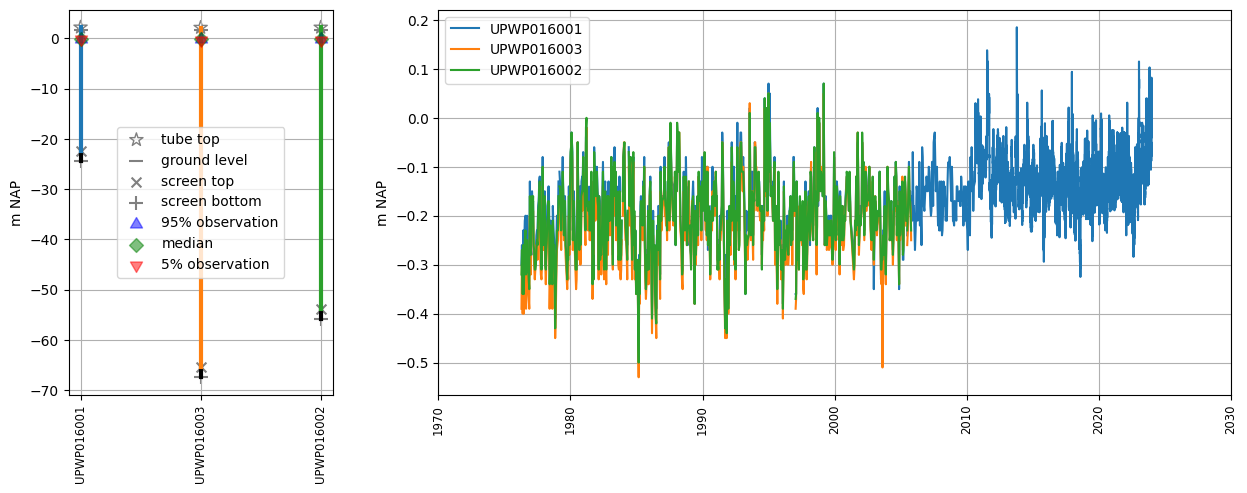

In [6]:
oc.plots.section_plot(plot_obs=True)

## Groundwater observations <a id=gwobs></a>

Now lets download the groundwater level observation using the `from_lizard` function of a `GroundwaterObs` object. The code below reads the groundwater level timeseries for the well UPWP016 from Lizard and makes a plot.

GroundwaterObs UPWP016001
-----metadata------
name : UPWP016001 
x : 137401.64297031244 
y : 458893.6835282785 
filename :  
source : lizard 
unit : m NAP 
monitoring_well : B31H0580 
tube_nr : 1 
screen_top : -22.43 
screen_bottom : -24.43 
ground_level : 1.58 
tube_top : 2.198 
metadata_available : True 

-----time series------
                     value         flag comment
peil_datum_tijd                                
1976-04-15 12:00:00 -0.300  betrouwbaar        
1976-04-28 12:00:00 -0.260  betrouwbaar        
1976-05-18 12:00:00 -0.330  betrouwbaar        
1976-06-02 12:00:00 -0.230  betrouwbaar        
1976-06-17 12:00:00 -0.300  betrouwbaar        
...                    ...          ...     ...
2024-01-03 21:00:00  0.059  betrouwbaar        
2024-01-04 00:00:00  0.059  betrouwbaar        
2024-01-04 03:00:00  0.062  betrouwbaar        
2024-01-04 06:00:00  0.066  betrouwbaar        
2024-01-04 09:00:00  0.078  betrouwbaar        

[29259 rows x 3 columns]


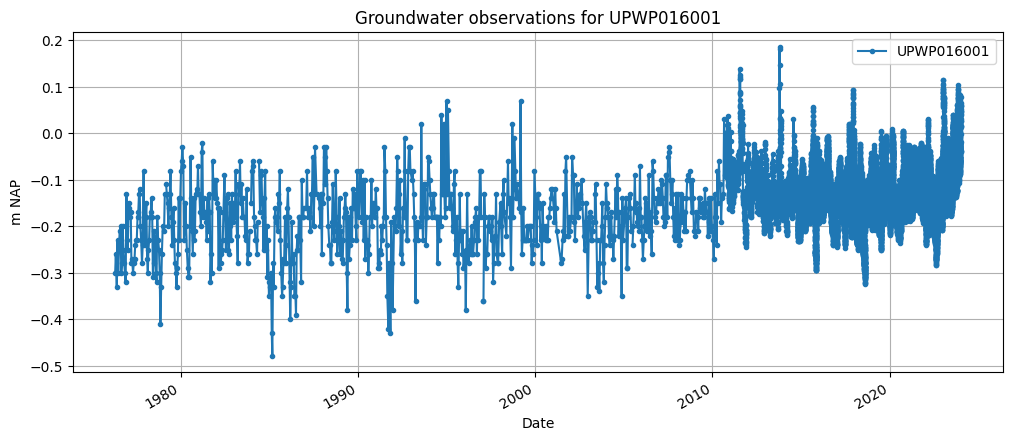

In [7]:

gw_lizard = hpd.GroundwaterObs.from_lizard("UPWP016", tmin="1900-01-01", tmax="2030-01-01")
print(gw_lizard)

ax = gw_lizard["value"].plot(
    figsize=(12, 5),
    marker=".",
    grid=True,
    label=gw_lizard.name,
    legend=True,
    xlabel="Date",
    ylabel="m NAP",
    title="Groundwater observations for " + gw_lizard.name,
)

The groundwater observations contain a validation flag per timestamp. These can 'betrouwbaar' (reliable), 'onbetrouwbaar' (unreliable) en 'onbeslist' (unvalidated). Below flags of the timeseries are shown as a percentage, and the unreliable timestamps are printed.

In [8]:
print(gw_lizard["flag"].value_counts(normalize=True) * 100)
gw_lizard[gw_lizard["flag"] == "onbetrouwbaar"]

UPWP016001
betrouwbaar      99.979493
onbetrouwbaar     0.017089
onbeslist         0.003418
Name: proportion, dtype: float64


,UPWP016001
x,137401.64297
y,458893.683528
filename,
source,lizard
unit,m NAP
monitoring_well,B31H0580
tube_nr,1
screen_top,-22.43
screen_bottom,-24.43
ground_level,1.58


## Pastas model <a id=pastas></a>

Lets make a Pastas model for this groundwater well (starting from 2015) and use the nearest KNMI station for meteorological data

INFO:hydropandas.io.knmi:get KNMI data from station nearest to coordinates (137401.64297031244, 458893.6835282785) and meteovariable RH
INFO:hydropandas.io.knmi:get KNMI data from station nearest to coordinates (137401.64297031244, 458893.6835282785) and meteovariable EV24


INFO: Time Series 'UPWP016001': 11 nan-value(s) was/were found and filled with: drop.


INFO:pastas.timeseries:Time Series 'UPWP016001': 11 nan-value(s) was/were found and filled with: drop.


INFO: Time Series 'RH_DE-BILT' was extended in the future to 2024-01-04 00:00:00 with the mean value (0.0024) of the time series.


INFO:pastas.timeseries:Time Series 'RH_DE-BILT' was extended in the future to 2024-01-04 00:00:00 with the mean value (0.0024) of the time series.


INFO: Time Series 'EV24_DE-BILT' was extended in the future to 2024-01-04 00:00:00 with the mean value (0.0017) of the time series.


INFO:pastas.timeseries:Time Series 'EV24_DE-BILT' was extended in the future to 2024-01-04 00:00:00 with the mean value (0.0017) of the time series.
Fit report UPWP016001              Fit Statistics
nfev    33                     EVP          62.73
nobs    3291                   R2            0.63
noise   True                   RMSE          0.03
tmin    2015-01-01 00:00:00    AIC      -29158.55
tmax    2024-01-04 09:00:00    BIC      -29121.96
freq    D                      Obj           0.23
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (6 optimized)
               optimal   stderr     initial  vary
rainevap_A   26.825256   ±2.49%  198.612463  True
rainevap_n    0.986379   ±0.58%    1.000000  True
rainevap_a   11.059931   ±3.43%   10.000000  True
rainevap_f   -0.192514  ±13.87%   -1.000000  True
constant_d   -0.193830   ±1.23%   -0.134993  True
noise_alpha  14.137844   ±3.30%    1.000000  True


[<Axes: xlabel='peil_datum_tijd'>,
 <Axes: xlabel='peil_datum_tijd'>,
 <Axes: title={'right': "Stresses: ['RH_DE-BILT', 'EV24_DE-BILT']"}>,
 <Axes: title={'center': 'Step response'}, xlabel='Time [days]'>,
 <Axes: title={'left': 'Model Parameters ($n_c$=6)'}>]

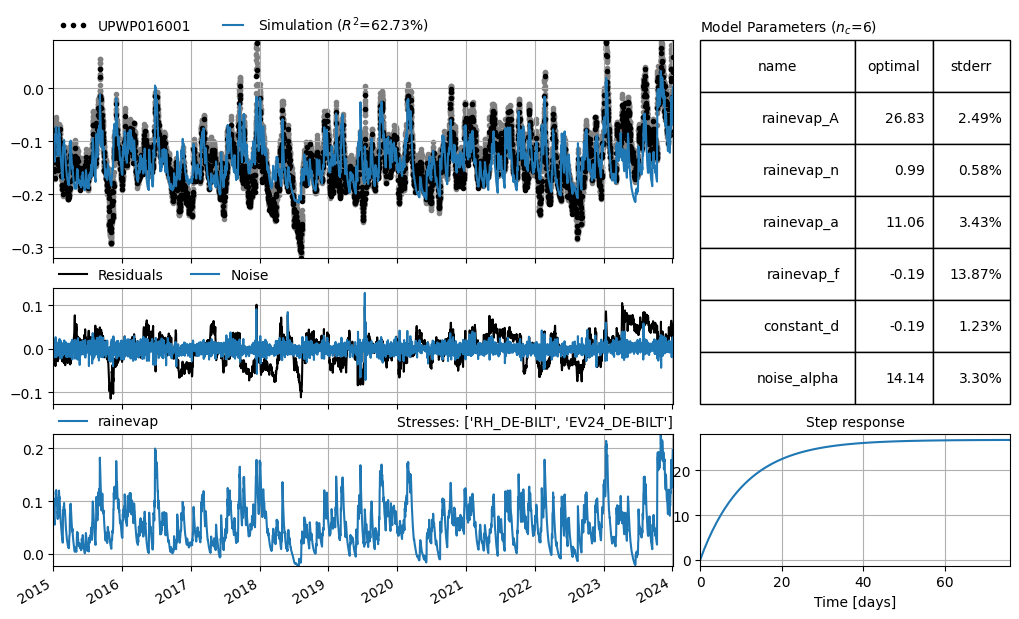

In [9]:
# Get the precipitation and evaporation data from the KNMI
precipitation = hpd.PrecipitationObs.from_knmi(
    xy=(gw_lizard.x, gw_lizard.y),
    start=gw_lizard.index[0],
    end=gw_lizard.index[-1],
    fill_missing_obs=True,
)
evaporation = hpd.EvaporationObs.from_knmi(
    xy=(gw_lizard.x, gw_lizard.y),
    meteo_var="EV24",
    start=gw_lizard.index[0],
    end=gw_lizard.index[-1],
    fill_missing_obs=True,
)

# Create a Pastas Model
ml = ps.Model(gw_lizard["value"], name=gw_lizard.name)

# Add the recharge data as explanatory variable
ts1 = ps.RechargeModel(
    precipitation["RH"].resample("D").first(),
    evaporation["EV24"].resample("D").first(),
    ps.Gamma(),
    name="rainevap",
    settings=("prec", "evap"),
)

# Add the stressmodel to the model and solve for period after 2015
ml.add_stressmodel(ts1)
ml.solve(tmin="2015")
ml.plots.results(figsize=(10, 6))